In [25]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [26]:
df = pd.read_csv(r'C:\python\tf\Churn.csv')
df.head(2)

,Customer ID,Gender,Senior Citizen,Partner,Dependents,tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEA,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [27]:
df.shape

(7044, 21)

In [28]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Senior Citizen'] = df['Senior Citizen'].replace({1: 'Yes', 0: 'No'})

In [29]:
q1 = df['Total Charges'].quantile(0.25)
q3 = df['Total Charges'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df = df[df['Total Charges'] < upper_bound]
df.shape

(7033, 21)

In [30]:
'''
mq1 = df['Monthly Charges'].quantile(0.25)
mq3 = df['Monthly Charges'].quantile(0.75)
miqr = mq3 - mq1
mlower_bound = mq1 - 1.5 * miqr
mupper_bound = mq3 + 1.5 * miqr
df = df[df['Monthly Charges'] > mlower_bound]
df = df[df['Monthly Charges'] < mupper_bound]
'''


"\nmq1 = df['Monthly Charges'].quantile(0.25)\nmq3 = df['Monthly Charges'].quantile(0.75)\nmiqr = mq3 - mq1\nmlower_bound = mq1 - 1.5 * miqr\nmupper_bound = mq3 + 1.5 * miqr\ndf = df[df['Monthly Charges'] > mlower_bound]\ndf = df[df['Monthly Charges'] < mupper_bound]\n"

Trimming the outliers in Monthly Charges doesn't imporve the score.

In [31]:
tq1 = df['tenure'].quantile(0.25)
tq3 = df['tenure'].quantile(0.75)
tiqr = tq3 - tq1
print(float(len((df[df['tenure'] > (tq1 + 1.5 * tiqr)]))/len(df)*100))

0.0


In [32]:
log_transformer = FunctionTransformer(np.log1p, validate=True)
df['Log Total Charges'] = log_transformer.transform(df[['Total Charges']])
# df['Log Monthly Charges'] = log_transformer.transform(df[['Monthly Charges']])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [33]:
'''
logq1 = df['Log Total Charges'].quantile(0.25)
logq3 = df['Log Total Charges'].quantile(0.75)
logiqr = logq3 - logq1
loglower_bound = logq3 - 1.5 * logiqr
df = df[df['Log Total Charges'] > loglower_bound]
'''

"\nlogq1 = df['Log Total Charges'].quantile(0.25)\nlogq3 = df['Log Total Charges'].quantile(0.75)\nlogiqr = logq3 - logq1\nloglower_bound = logq3 - 1.5 * logiqr\ndf = df[df['Log Total Charges'] > loglower_bound]\n"

Filtering out the outliters in Log Total Charges column reduces the score to 0.7897 from 0.7341

monthly charges do not follow log normal distribution

In [34]:
df.drop(columns = 'Total Charges', inplace=True)
# df.drop(columns = 'Monthly Charges', inplace=True)

In [35]:
'''
qt = QuantileTransformer(output_distribution='uniform', random_state=0)
df['QT Monthly Charges'] = qt.fit_transform(df[['Monthly Charges']])
'''

"\nqt = QuantileTransformer(output_distribution='uniform', random_state=0)\ndf['QT Monthly Charges'] = qt.fit_transform(df[['Monthly Charges']])\n"

In [36]:
# df.drop(columns = 'Monthly Charges', inplace=True)

Uniform distribution transformation of Monthly Charges doesn't improve the score.

In [37]:
'''
standard_scaler = StandardScaler()
df['Standardized Monthly Charges'] = standard_scaler.fit_transform(df[['Monthly Charges']])
df.drop(columns = 'Monthly Charges', inplace=True)
'''

"\nstandard_scaler = StandardScaler()\ndf['Standardized Monthly Charges'] = standard_scaler.fit_transform(df[['Monthly Charges']])\ndf.drop(columns = 'Monthly Charges', inplace=True)\n"

Using standard scaler on Monthly Charges doesn't change anything.

In [38]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(df[['Monthly Charges']])

log_density = kde.score_samples(df[['Monthly Charges']])
df['KDE Monthly Charges'] = np.exp(log_density)

df.drop(columns = 'Monthly Charges', inplace=True)

Gaussian Kernel Density Estimation transformation of Monthly Charges improves the score to 0.7911 from 0.78977

In [39]:
kde.fit(df[['tenure']])
tenure_log_density = kde.score_samples(df[['tenure']])
df['KDE Tenure'] = np.exp(tenure_log_density)
df.drop(columns = 'tenure', inplace=True)


In [40]:
df['KDE Log Tenure'] = log_transformer.transform(df[['KDE Tenure']])
df['KDE log Monthtly Charges'] = log_transformer.transform(df[['KDE Monthly Charges']])
df.drop(columns = ['KDE Tenure', 'KDE Monthly Charges'], inplace=True)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


No tenure outliers

In [41]:
df.dtypes

Customer ID                  object
Gender                       object
Senior Citizen               object
Partner                      object
Dependents                   object
Phone Service                object
Multiple Lines               object
Internet Service             object
Online Security              object
Online Backup                object
Device Protection            object
Tech Support                 object
Streaming TV                 object
Streaming Movies             object
Contract                     object
Paperless Billing            object
Payment Method               object
Churn                        object
Log Total Charges           float64
KDE Log Tenure              float64
KDE log Monthtly Charges    float64
dtype: object

In [42]:
df.describe(include='all')

,Customer ID,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn,Log Total Charges,KDE Log Tenure,KDE log Monthtly Charges
count,7033,7033,7033,7033,7033,7033,7033,7033,7033,7033,...,7033,7033,7033,7033,7033,7033,7033,7033.000000,7033.000000,7033.000000
unique,7033,2,2,2,2,2,3,3,3,3,...,3,3,3,3,2,4,2,NaN,NaN,NaN
top,3186-AJIEK,Male,No,No,No,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,No,NaN,NaN,NaN
freq,1,3549,5891,3639,4934,6352,3385,3096,3498,3087,...,3473,2810,2782,3876,4169,2366,5164,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.942887,0.042984,0.026220
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.546896,0.041079,0.029512
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.985682,0.014082,0.000329
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.997198,0.019659,0.009027
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.243012,0.026311,0.016199
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.241571,0.047090,0.023674


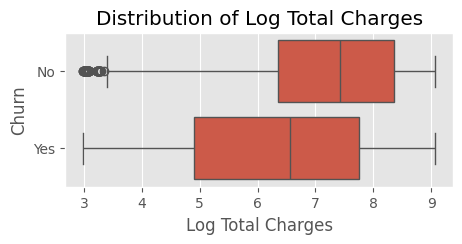

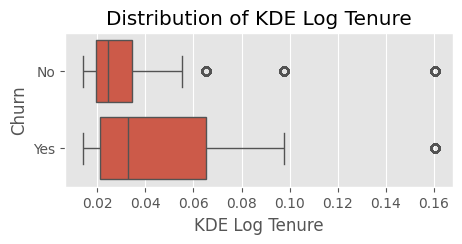

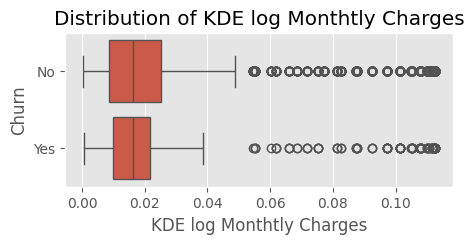

In [43]:
numeric_cols = df.select_dtypes('number').columns
for i in numeric_cols:
    plt.figure(figsize = (5, 2))
    plt.style.use('ggplot')
    sns.boxplot(data = df, x = i, y = 'Churn')
    plt.title(f'Distribution of {i}')
    plt.show()

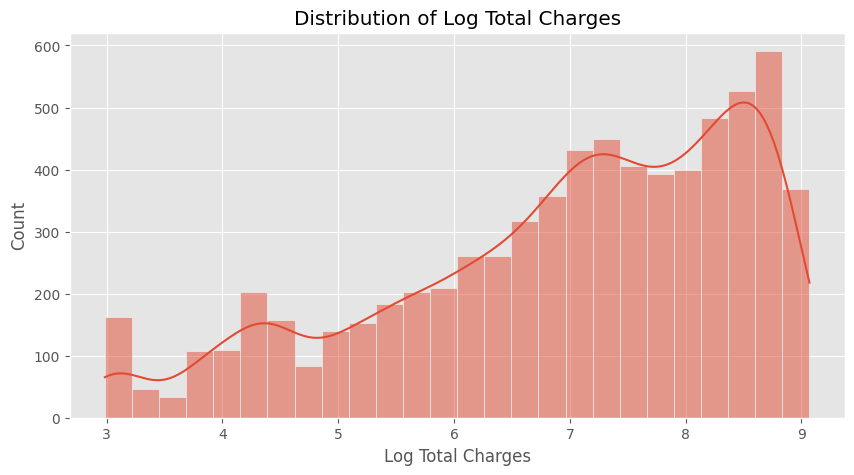

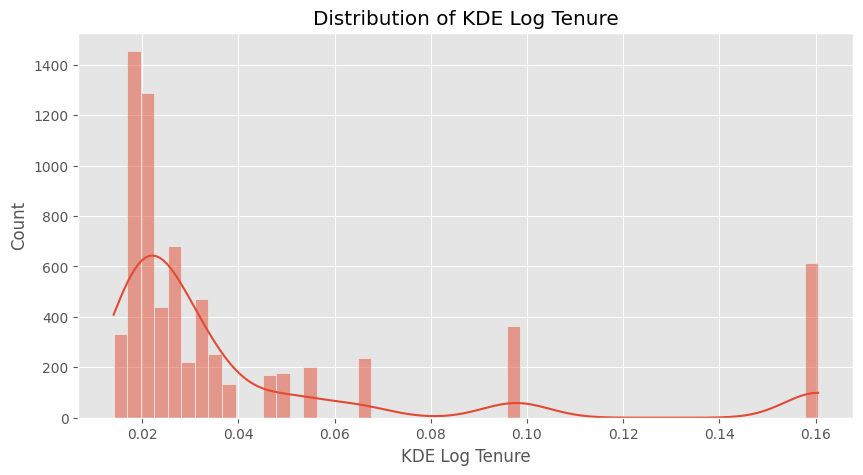

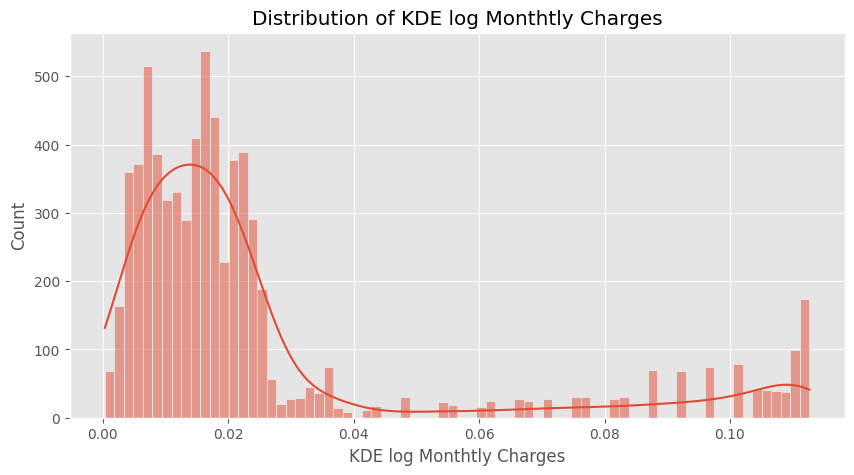

In [44]:

for i in numeric_cols:
    plt.figure(figsize = (10, 5))
    plt.style.use('ggplot')
    sns.histplot(data = df, x = i, kde=True)
    plt.title(f'Distribution of {i}')
    plt.show()

<Axes: >

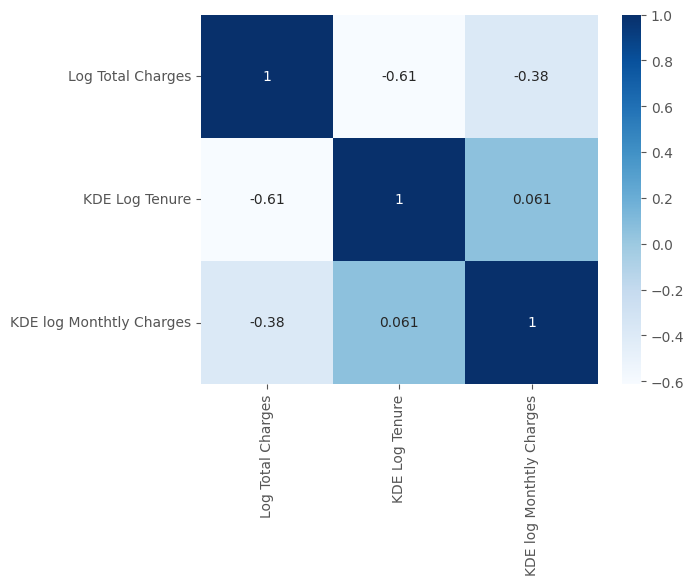

In [45]:
sns.heatmap(df.select_dtypes('number').corr(), annot = True, cmap='Blues')

In [46]:
df.isna().sum()

Customer ID                 0
Gender                      0
Senior Citizen              0
Partner                     0
Dependents                  0
Phone Service               0
Multiple Lines              0
Internet Service            0
Online Security             0
Online Backup               0
Device Protection           0
Tech Support                0
Streaming TV                0
Streaming Movies            0
Contract                    0
Paperless Billing           0
Payment Method              0
Churn                       0
Log Total Charges           0
KDE Log Tenure              0
KDE log Monthtly Charges    0
dtype: int64

In [47]:
df.shape

(7033, 21)

There are no null values

In [48]:
numercial_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

numercial_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numercial_transformer, numeric),
        ('cat', categorical_transformer, categorical)
    ]
)
preprocessor

NameError: name 'numeric' is not defined

In [ ]:
X = pd.get_dummies(df.drop(columns=['Customer ID','Churn']), drop_first=True)
y = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42, stratify=y)
X_train.head(2)

,Log Total Charges,KDE Log Tenure,KDE log Monthtly Charges,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
1443,8.565116,0.022436,0.018003,False,False,True,True,True,False,False,...,False,True,False,True,True,False,False,False,True,False
3532,5.692216,0.022436,0.068566,False,False,False,False,True,False,False,...,True,False,True,False,True,False,False,True,False,False


In [ ]:
numeric = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Categorical columns: {categorical}\nNumeric columns: {numeric}')
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
categorical_transformer

In [ ]:
y_train.head(2)

1443    0
3532    0
Name: Churn, dtype: int64

In [ ]:
'''model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_transformed.shape[1]))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
'''

"model = Sequential()\nmodel.add(Dense(units=32, activation='relu', input_dim=X_train_transformed.shape[1]))\nmodel.add(Dense(units=64, activation='relu'))\nmodel.add(Dense(units=1, activation='sigmoid'))\nmodel.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])\n"

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score


In [ ]:
model = Sequential()
model.add(Dense(units = 32, activation='relu', input_dim = len(X_train.columns)))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = 30, batch_size=128)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5072 - loss: 0.7231   
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7301 - loss: 0.5332 
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7337 - loss: 0.5210
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7290 - loss: 0.5099 
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.7312 - loss: 0.4977
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.7369 - loss: 0.4872
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7393 - loss: 0.4771
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.7490 - loss: 0.4670
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7585 - loss: 0.4724 
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.7746 - loss: 0.4492
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.7792 - loss: 0.4480
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step -

In [ ]:
y_hat = model.predict(X_test)
y_hat = [0 if i<0.5 else 1 for i in y_hat]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
accuracy_score(y_test, y_hat)

0.7954545454545454

0.8011363636363636

- after the log-normal transformation of total charges added and dropping the total charges column

- also making the monthly charges and tenure columns into kernel density estimation and converting it to an exponential scale and dropping the monthly charges column

- finally log-normal transformation of kde tenure and kde monthly charges


lowest score I had was 0.72

In [ ]:
import xgboost as xgb

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state = 42, eval_metric = 'logloss'))
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Log Total Charges',
                                                   'KDE Log Tenure',
                                                   'KDE log Monthtly Charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 XGBClass...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

gcv = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1,
    verbose = 1
)


In [ ]:
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Log '
                                                                          'Total '
                                                                          'Charges',
                                                                          'KDE '
                                                                          'Log '
                                                                          'Tenure',
                                                                          'KDE '
                                                                          'log '
                                                                          'Monthtly '
                                                                          'Charges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown=...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=1,
             param_grid={'classifier__colsample_bytree': [0.8, 0.9, 1.0],
                         'classifier__gamma': [0, 0.1, 0.2],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5, 6],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
model2 = gcv.best_estimator_

In [ ]:
y2_hat = model2.predict(X_test)

In [ ]:
model2_accuracy = accuracy_score(y_test, y2_hat)
model2_accuracy
model2_cr = classification_report(y_test, y2_hat)
model_cr = classification_report(y_test, y_hat)
print("Classification Report for XGBoost\n", model2_cr)
print("Classification Report for Tensroflow\n", model_cr)

Classification Report for XGBoost
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       517
           1       0.62      0.37      0.46       187

    accuracy                           0.77       704
   macro avg       0.71      0.64      0.66       704
weighted avg       0.75      0.77      0.75       704

Classification Report for Tensroflow
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       517
           1       0.66      0.48      0.55       187

    accuracy                           0.80       704
   macro avg       0.74      0.69      0.71       704
weighted avg       0.78      0.80      0.78       704



In [ ]:
model2_cm = confusion_matrix(y_test, y2_hat)
model_cm = confusion_matrix(y_test, y_hat)
print("Confusion Matrix for XGBoost\n", model2_cm)
print("Confusion Matrix for Tensorflow\n", model_cm)

Confusion Matrix for XGBoost
 [[475  42]
 [118  69]]
Confusion Matrix for Tensorflow
 [[471  46]
 [ 98  89]]


In [ ]:
model2_roc = roc_auc_score(y_test, y2_hat)
model_roc = roc_auc_score(y_test, y_hat)
print("ROC for XGBoost\n", model2_cm)
print("ROC for Tensorflow\n", model_cm)

ROC for XGBoost
 [[475  42]
 [118  69]]
ROC for Tensorflow
 [[471  46]
 [ 98  89]]


In [ ]:
from sklearn.metrics import f1_score

tf_f1 = f1_score(y_test, y_hat)
xgb_f1 = f1_score(y_test, y2_hat)
print(f'Tensorflow F1 Score is: {tf_f1}\nXGBoost F1 Score is: {xgb_f1}')

Tensorflow F1 Score is: 0.5527950310559007
XGBoost F1 Score is: 0.46308724832214765


Overall Tensorflow seems to be the winner

In [ ]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
param_grid2 = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l2']
}
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Log Total Charges',
                                                   'KDE Log Tenure',
                                                   'KDE log Monthtly Charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
gcv_lr = GridSearchCV(
    estimator= pipeline_lr,
    cv = 5,
    scoring='accuracy',
    param_grid=param_grid2,
    n_jobs = 1, 
    verbose = 1
)

gcv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Log '
                                                                          'Total '
                                                                          'Charges',
                                                                          'KDE '
                                                                          'Log '
                                                                          'Tenure',
                                                                          'KDE '
                                                                          'log '
                                                                          'Monthtly '
                                                                          'Charges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__penalty': ['l2']},
             scoring='accuracy', verbose=1)

In [ ]:
model3_lr = gcv_lr.best_estimator_

y3_hat = model3_lr.predict(X_test)

print(accuracy_score(y_test, y3_hat))

0.7457386363636364


In [ ]:
print(classification_report(y_test, y3_hat))

              precision    recall  f1-score   support

           0       0.77      0.94      0.84       517
           1       0.56      0.21      0.30       187

    accuracy                           0.75       704
   macro avg       0.66      0.57      0.57       704
weighted avg       0.71      0.75      0.70       704

